Looking for data in: /home/tim/final-pipeline/configf_1061/analysis_output
Loading data from configf_1061/analysis_output...
Loaded radial_outer_data: shape (101, 3072)
Loaded radial_inner_data: shape (101, 768)
Loaded nmfk_phase_map_OUTER_UNS_vs_SAT.npy: shape (101, 3072)
Loaded nmfk_phase_map_OUTER_SAT_vs_CHOL.npy: shape (101, 3072)
Loaded nmfk_phase_map_OUTER_CHOL_vs_UNS.npy: shape (101, 3072)
Loaded nmfk_phase_map_INNER_UNS_vs_SAT.npy: shape (101, 768)
Loaded nmfk_phase_map_INNER_SAT_vs_CHOL.npy: shape (101, 768)
Loaded nmfk_phase_map_INNER_CHOL_vs_UNS.npy: shape (101, 768)
Selected frame indices for plotting: [  0  11  22  33  44  55  66  77  88 100]


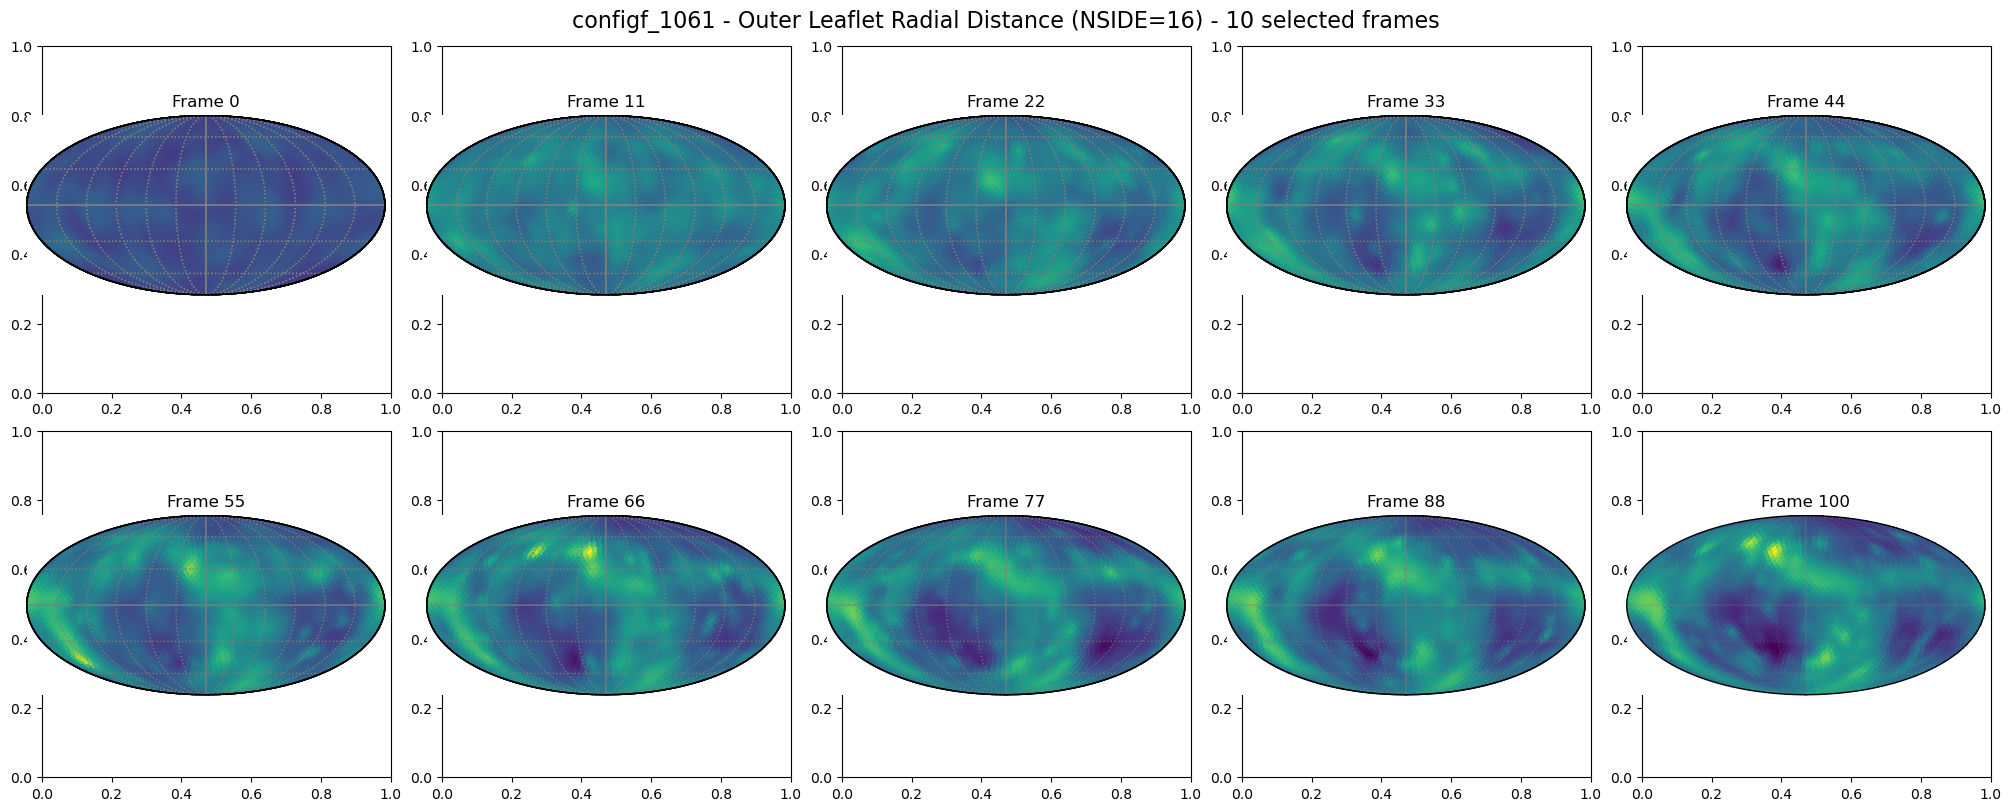

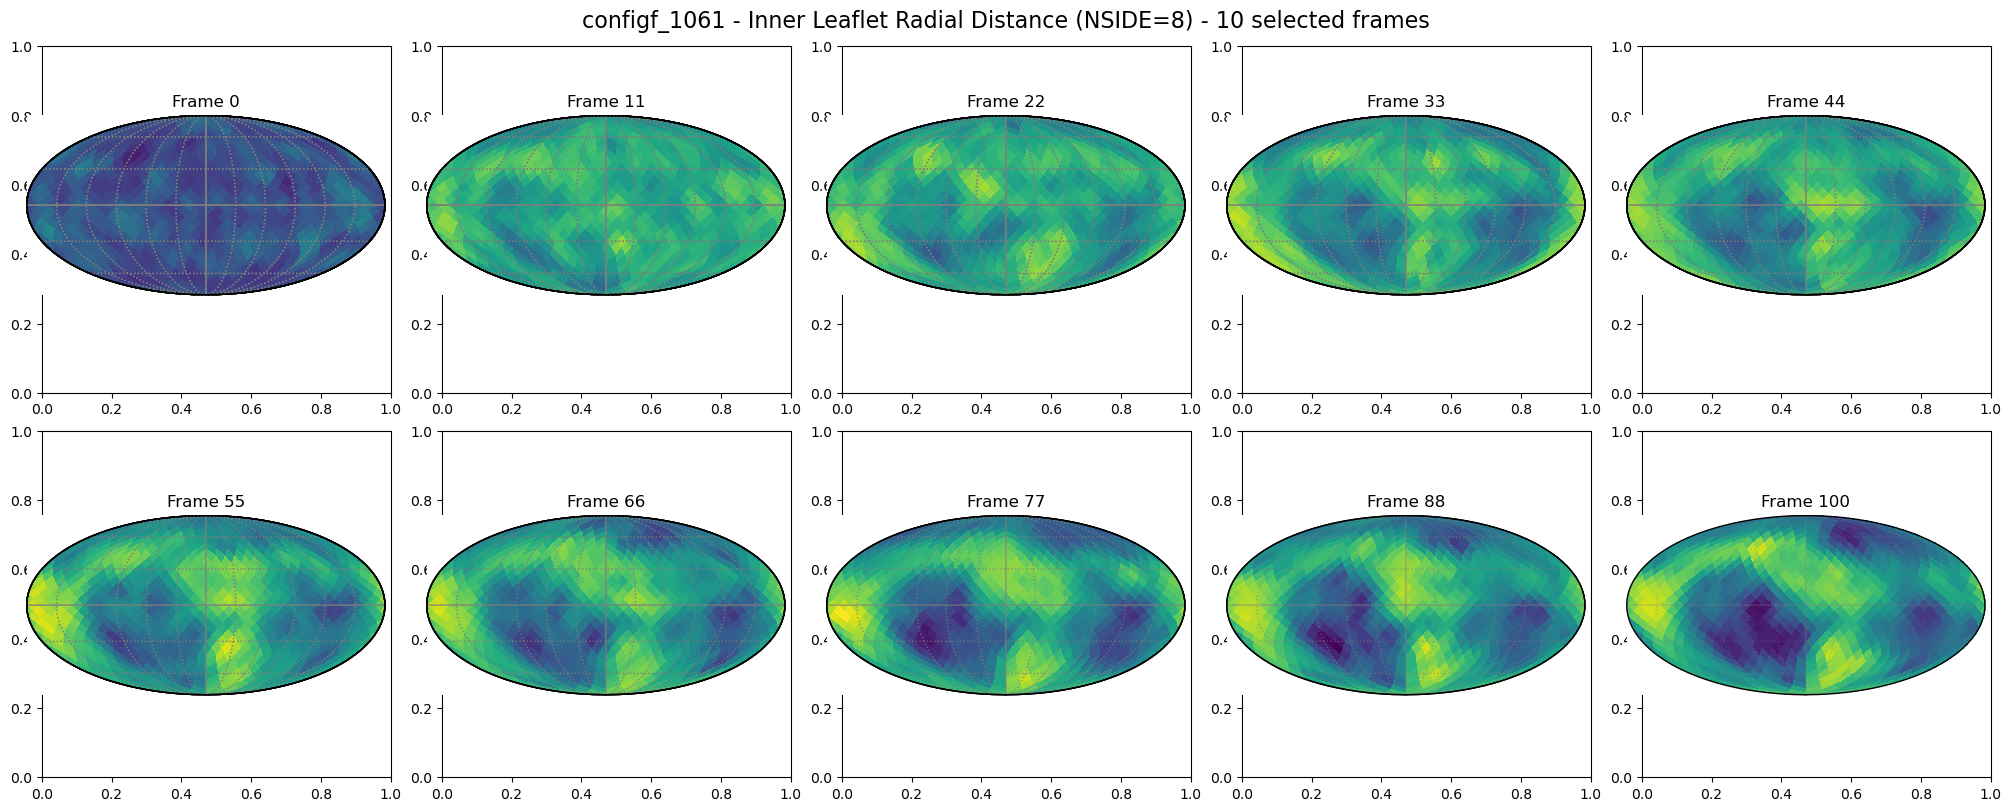

Plotting NMFk for OUTER - UNS_vs_SAT. Data has 3072 pixels, effective NSIDE for plotting: 16.


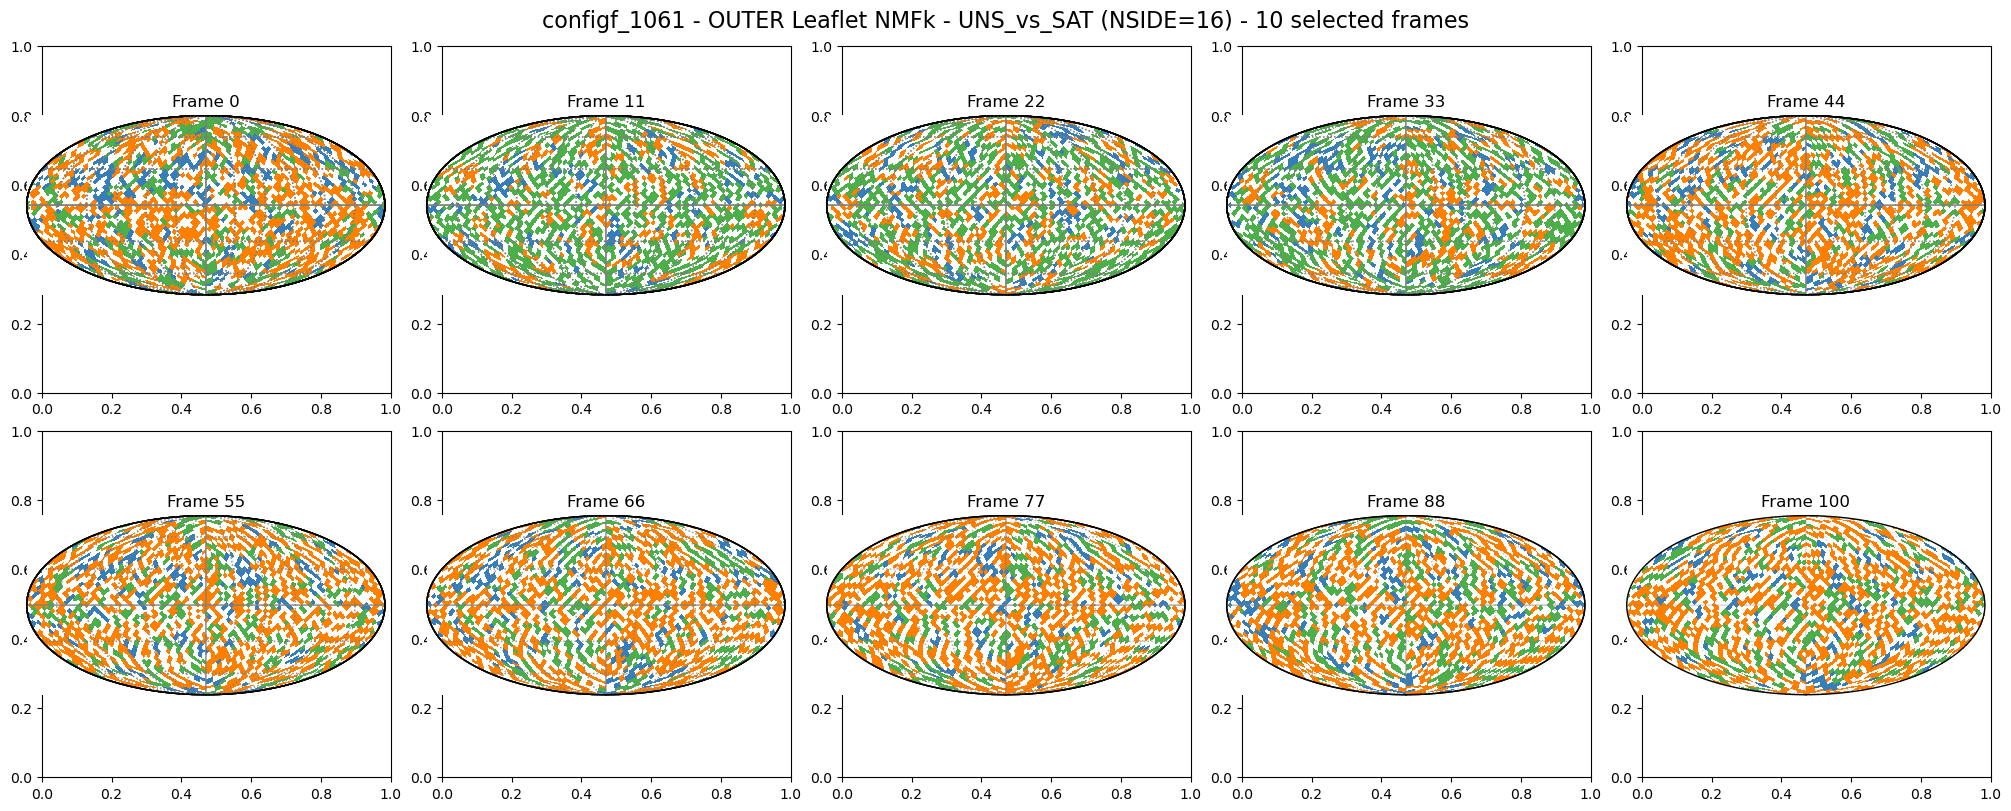

Plotting NMFk for OUTER - SAT_vs_CHOL. Data has 3072 pixels, effective NSIDE for plotting: 16.


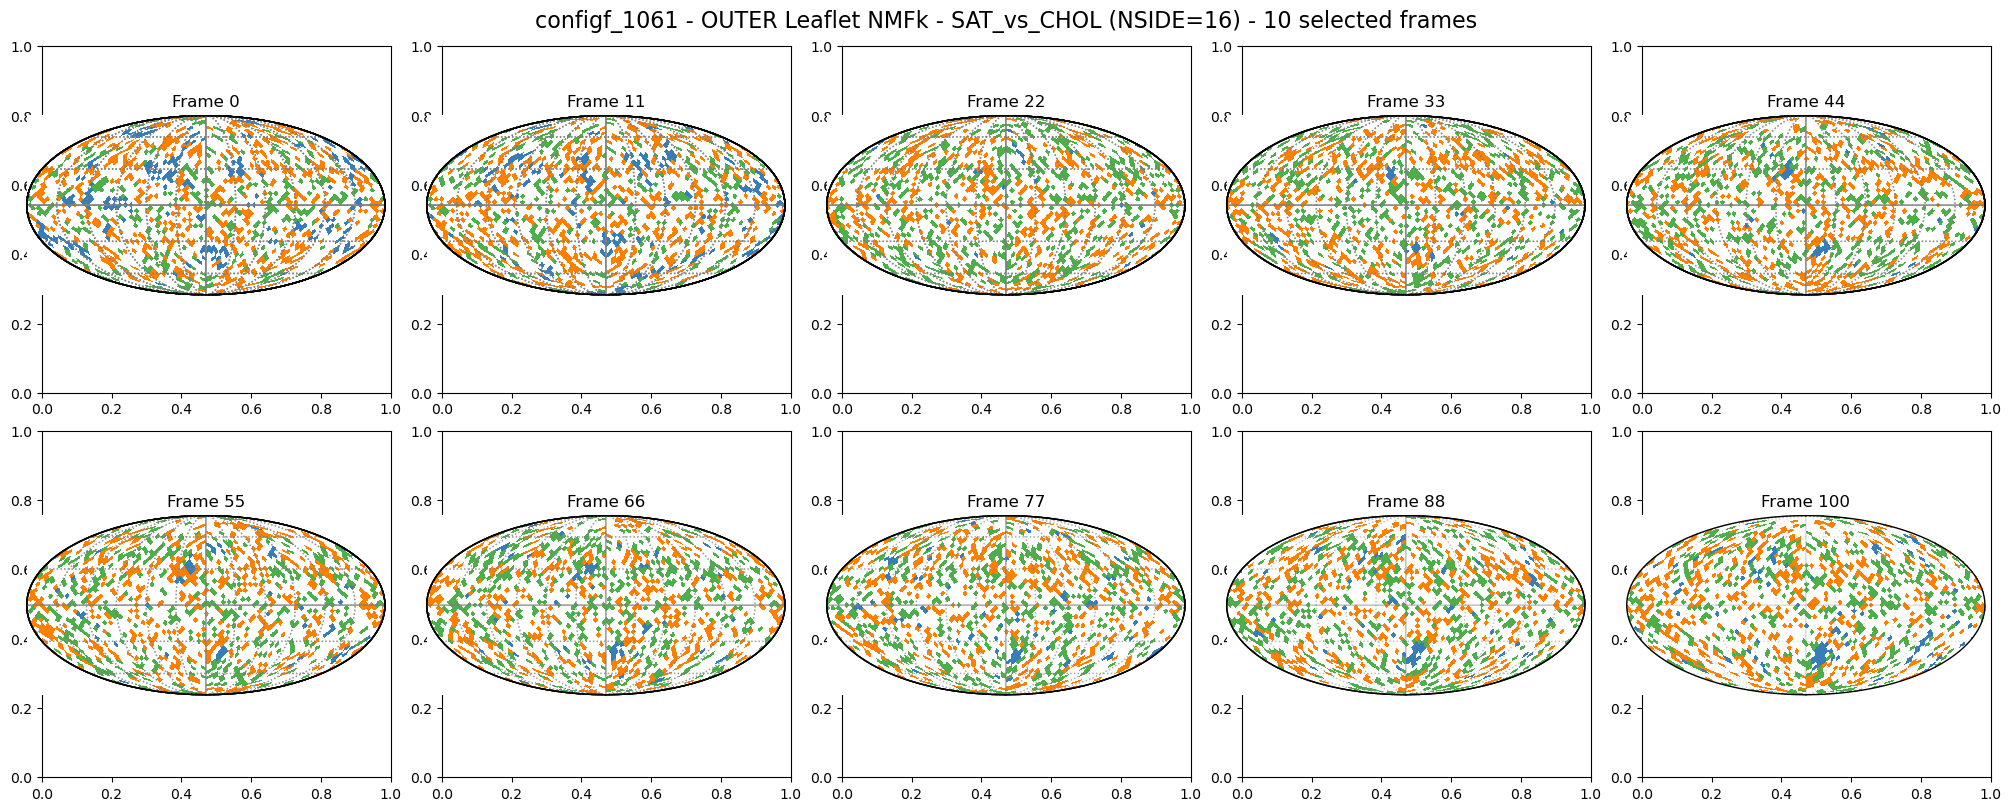

Plotting NMFk for OUTER - CHOL_vs_UNS. Data has 3072 pixels, effective NSIDE for plotting: 16.


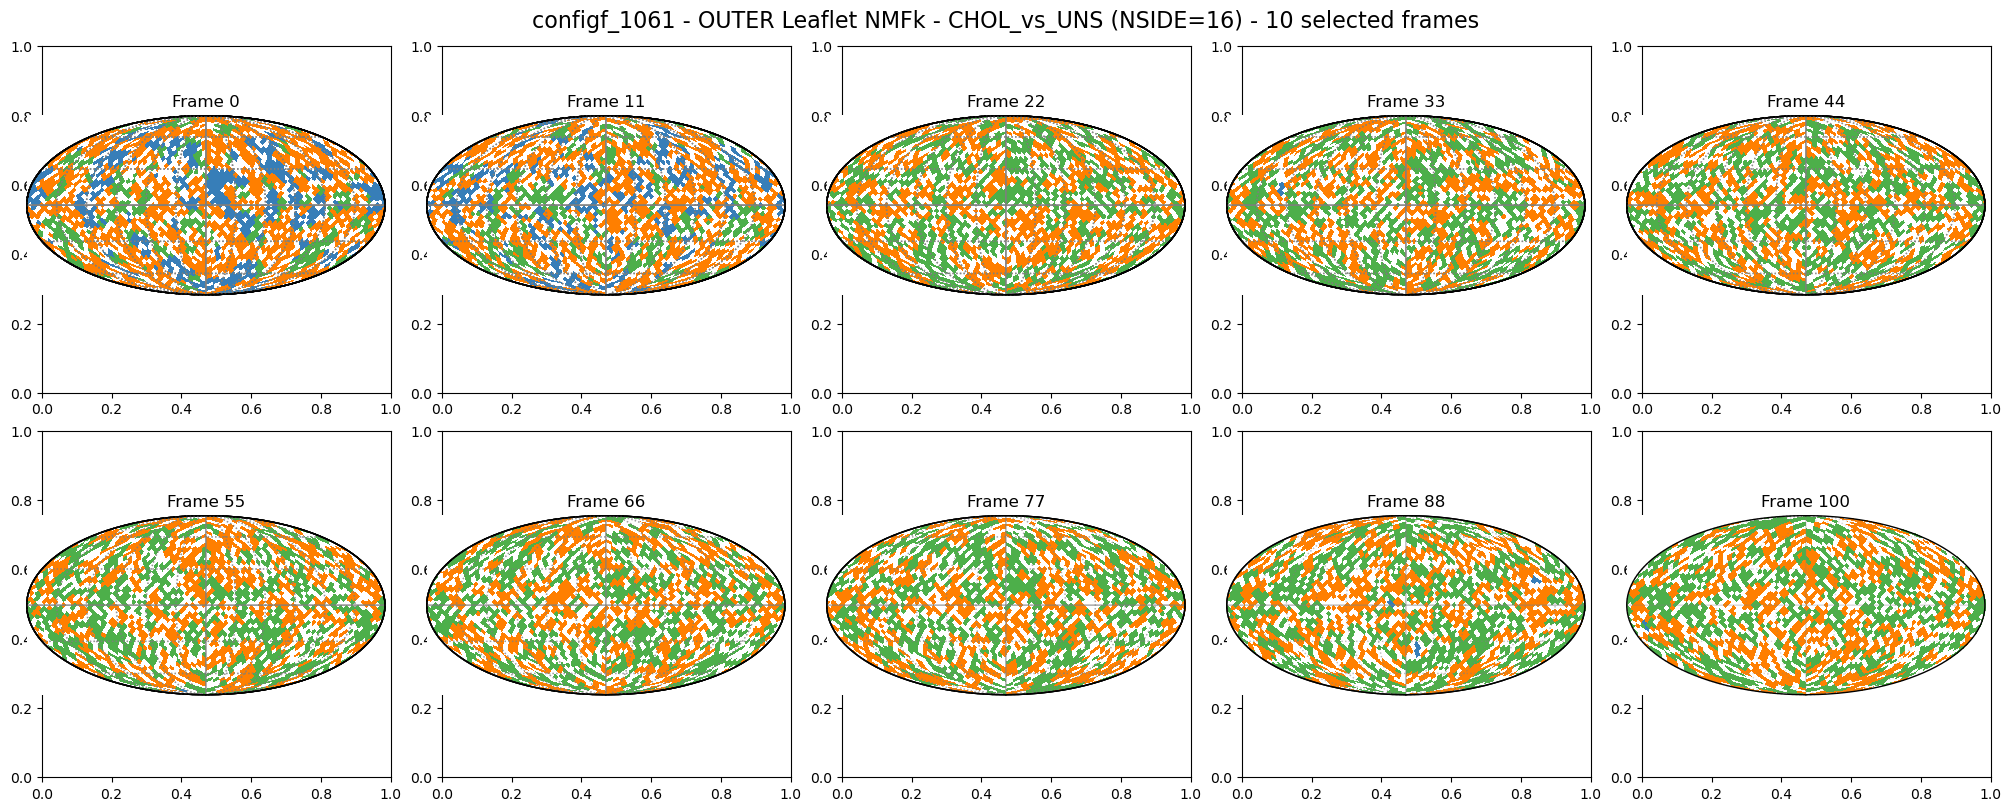

Plotting NMFk for INNER - UNS_vs_SAT. Data has 768 pixels, effective NSIDE for plotting: 8.


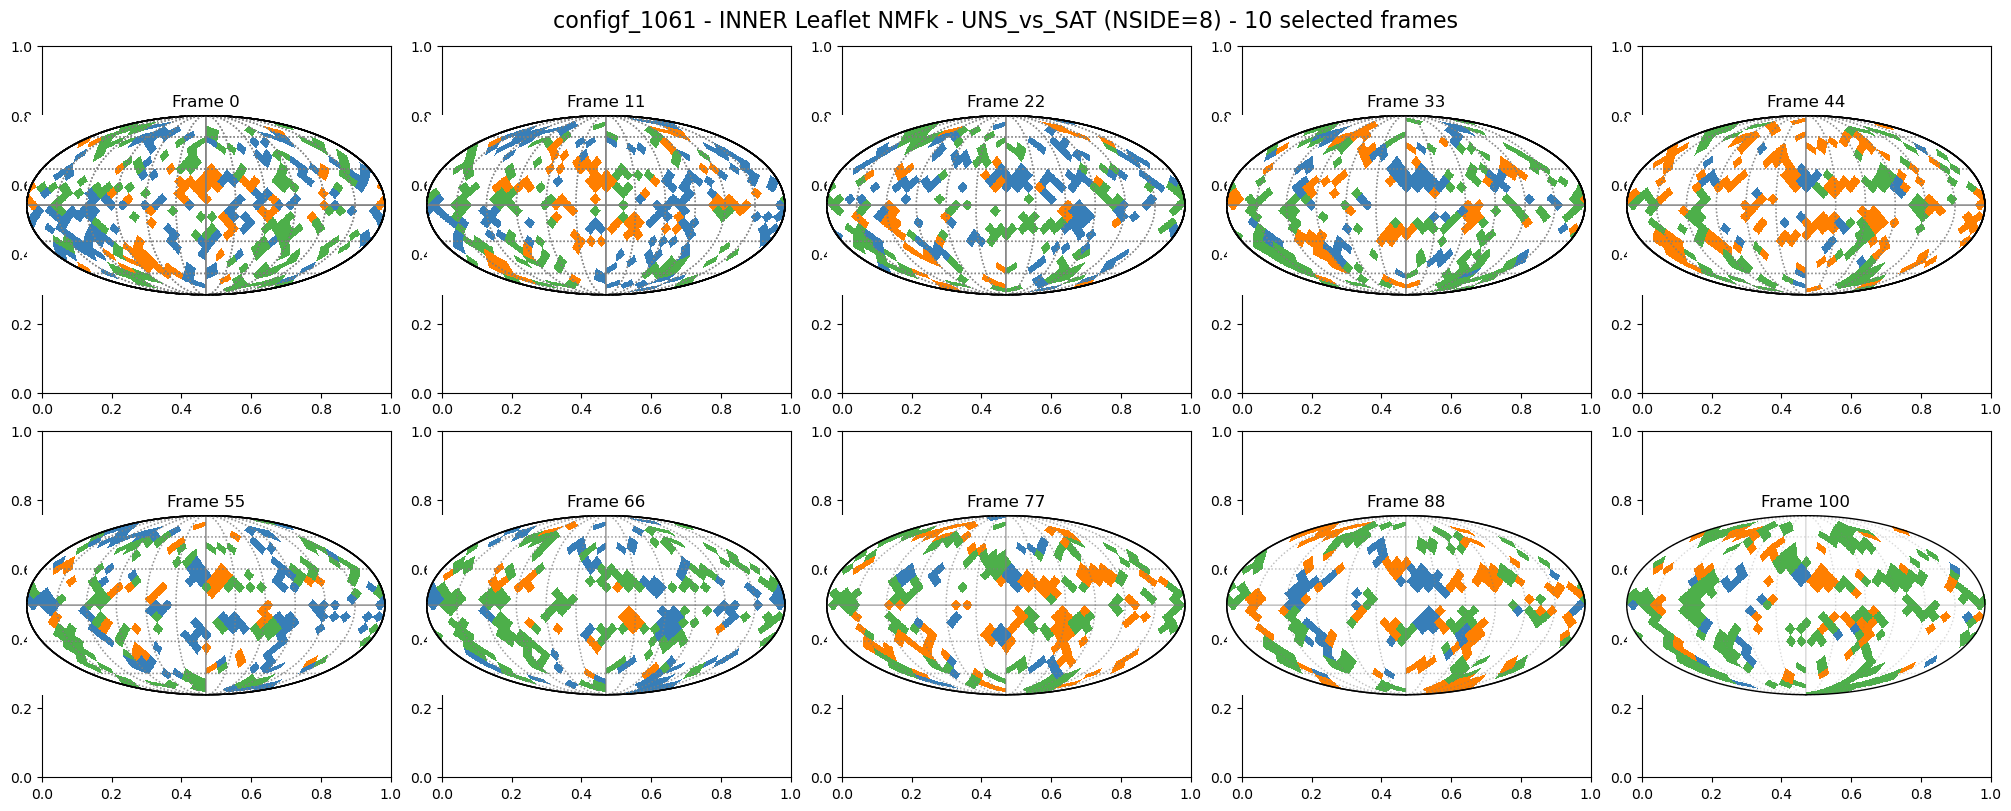

Plotting NMFk for INNER - SAT_vs_CHOL. Data has 768 pixels, effective NSIDE for plotting: 8.


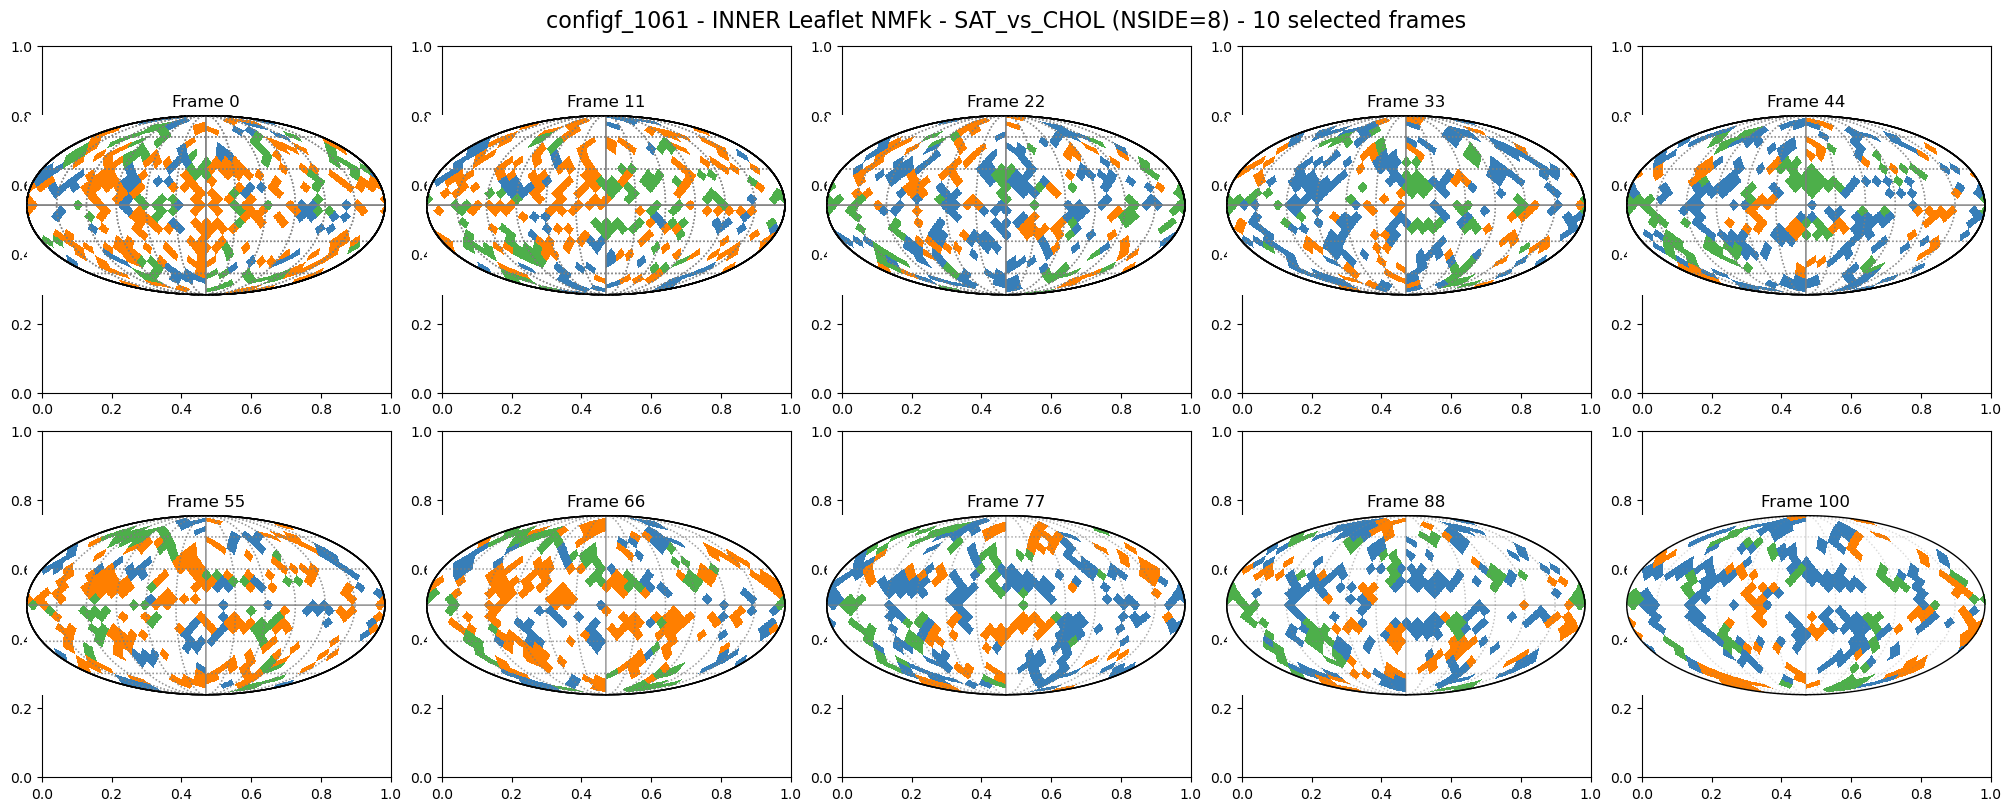

Plotting NMFk for INNER - CHOL_vs_UNS. Data has 768 pixels, effective NSIDE for plotting: 8.


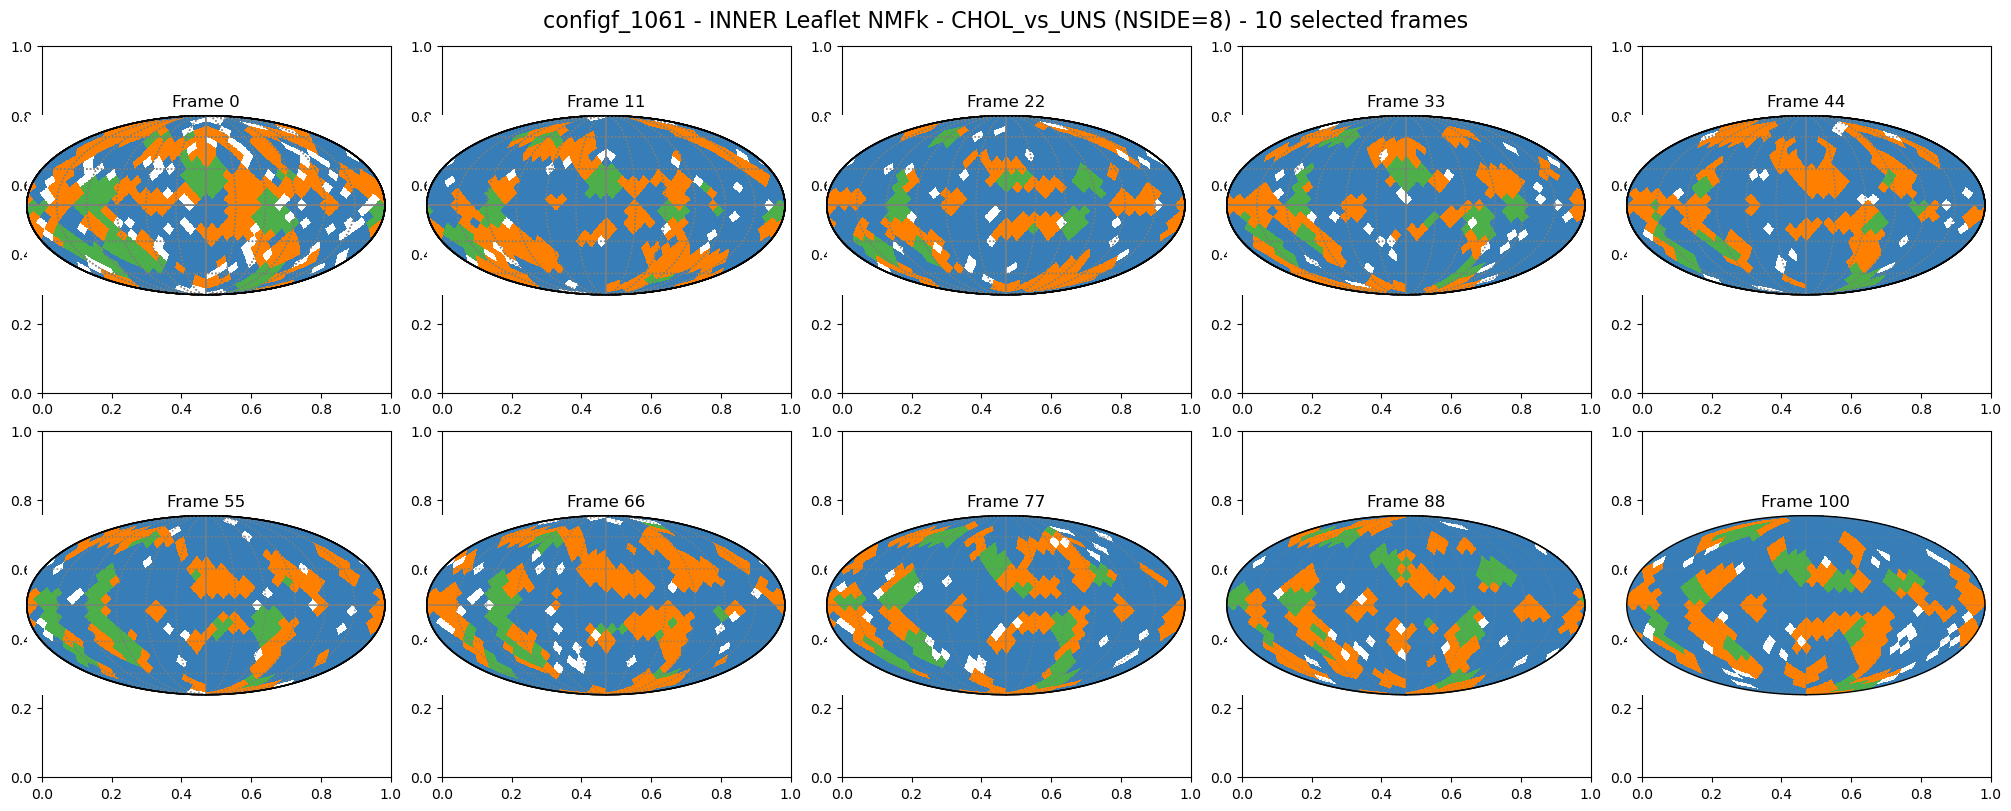

--- Plotting complete (if data was available) ---
--- Plotting complete (if data was available) ---


In [1]:
# Cell 1: Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import matplotlib.colors

# Cell 2: Configuration
# --- Parameters from the analysis script (ensure these match what was used) ---
BASE_CONFIG_FOLDER = "configf_1061"  # The specific config folder you want to analyze
ANALYSIS_SUBDIR = "analysis_output"

# NSIDE values used during analysis
NSIDE_OUTER_RADIAL = 16
NSIDE_INNER_RADIAL = 8
NSIDE_NMFK_PHASE_MAP = 16 # Used for both inner and outer NMFk maps in the previous script

# NMFk parameters for colormap
K_CLUSTERS_FINAL_KMEANS = 3 # Number of clusters used in KMeans after NMF

# Lipid pairs (must match the order and naming from the analysis script)
LIPID_PAIR_NAMES = [
    "UNS_vs_SAT",
    "SAT_vs_CHOL",
    "CHOL_vs_UNS"
]

N_FRAMES_TO_PLOT = 10

# --- Construct path to the analysis output ---
data_path = os.path.join(BASE_CONFIG_FOLDER, ANALYSIS_SUBDIR)

print(f"Looking for data in: {os.path.abspath(data_path)}")

# Cell 3: Load Data
print(f"Loading data from {data_path}...")

try:
    # Radial distance maps
    radial_outer_data = np.load(os.path.join(data_path, "area_outer_radial_dist.npy"))
    radial_inner_data = np.load(os.path.join(data_path, "area_inner_radial_dist.npy"))
    print(f"Loaded radial_outer_data: shape {radial_outer_data.shape}")
    print(f"Loaded radial_inner_data: shape {radial_inner_data.shape}")

    # NMFk phase maps
    nmfk_maps = {
        "OUTER": {},
        "INNER": {}
    }
    for leaflet_name in ["OUTER", "INNER"]:
        for pair_name in LIPID_PAIR_NAMES:
            filename = f"nmfk_phase_map_{leaflet_name}_{pair_name}.npy"
            try:
                nmfk_maps[leaflet_name][pair_name] = np.load(os.path.join(data_path, filename))
                print(f"Loaded {filename}: shape {nmfk_maps[leaflet_name][pair_name].shape}")
            except FileNotFoundError:
                print(f"ERROR: File not found: {os.path.join(data_path, filename)}")
                nmfk_maps[leaflet_name][pair_name] = None # Placeholder
except FileNotFoundError as e:
    print(f"ERROR: Could not load one or more data files. Please check the path and ensure analysis was completed for {BASE_CONFIG_FOLDER}.")
    print(e)
    # You might want to raise an error or exit if data loading fails critically
    # For now, we'll allow it to continue so missing NMFk maps can be identified.
except Exception as e:
    print(f"An unexpected error occurred during data loading: {e}")


# Cell 4: Frame Selection
# Determine the total number of frames from one of the loaded arrays (assuming all have the same n_frames)
if 'radial_outer_data' in locals() and radial_outer_data is not None:
    total_frames_available = radial_outer_data.shape[0]
    if total_frames_available == 0:
        print("Error: Loaded data has 0 frames.")
        selected_frame_indices = []
    elif total_frames_available < N_FRAMES_TO_PLOT:
        selected_frame_indices = np.arange(total_frames_available)
        print(f"Warning: Only {total_frames_available} frames available, plotting all of them.")
    else:
        # Select 10 evenly spaced frames, including the first and last if possible
        selected_frame_indices = np.linspace(0, total_frames_available - 1, N_FRAMES_TO_PLOT, dtype=int)
    print(f"Selected frame indices for plotting: {selected_frame_indices}")
else:
    print("Cannot determine frames to plot as radial_outer_data was not loaded.")
    selected_frame_indices = []


# Cell 5: Plotting Setup and Helper Function

# Colormap for NMFk (categorical)
# Adjust colors if K_CLUSTERS_FINAL_KMEANS is different
nmfk_plot_colors = ['#377eb8', '#ff7f00', '#4daf4a', '#f781bf', '#a65628', '#984ea3', '#999999', '#e41a1c', '#dede00'] # From Colorbrewer Set1
if K_CLUSTERS_FINAL_KMEANS > len(nmfk_plot_colors):
    # Fallback to a default matplotlib cmap if more clusters than defined colors
    print(f"Warning: K_CLUSTERS_FINAL_KMEANS ({K_CLUSTERS_FINAL_KMEANS}) is greater than defined nmfk_plot_colors. Using fallback.")
    # Create a ListedColormap from a standard cmap
    _cmap = plt.cm.get_cmap('viridis', K_CLUSTERS_FINAL_KMEANS)
    cmap_nmfk = matplotlib.colors.ListedColormap([_cmap(i) for i in range(K_CLUSTERS_FINAL_KMEANS)])
else:
    cmap_nmfk = matplotlib.colors.ListedColormap(nmfk_plot_colors[:K_CLUSTERS_FINAL_KMEANS])

norm_nmfk = matplotlib.colors.BoundaryNorm(np.arange(-0.5, K_CLUSTERS_FINAL_KMEANS + 0.5, 1), cmap_nmfk.N)


def plot_healpix_frames(data_array, frame_indices, nside, title_prefix,
                        is_nmfk=False, cmap_val='viridis', norm_val=None, unit_label="Value"):
    """Plots 10 selected frames of Healpix data in a 2x5 grid."""
    if data_array is None or len(frame_indices) == 0:
        print(f"Skipping plotting for {title_prefix}: Data not available or no frames selected.")
        return

    n_plots = len(frame_indices)
    if n_plots == 0: return

    fig, axes = plt.subplots(nrows=max(1, (n_plots + 4) // 5), ncols=5, figsize=(20, 4 * max(1, (n_plots + 4) // 5)),
                             constrained_layout=True)
    axes = np.atleast_2d(axes) # Ensure axes is 2D for consistent indexing
    fig.suptitle(f"{title_prefix} (NSIDE={nside}) - {N_FRAMES_TO_PLOT} selected frames", fontsize=16)

    # Determine global min/max for radial data if not NMFk for consistent color scaling across frames
    global_min, global_max = (None, None)
    if not is_nmfk:
        valid_data = data_array[frame_indices, :][~np.isnan(data_array[frame_indices, :])]
        if valid_data.size > 0:
            global_min = np.min(valid_data)
            global_max = np.max(valid_data)
        else: # All NaNs
            global_min, global_max = 0, 1


    for i, frame_idx in enumerate(frame_indices):
        row, col = divmod(i, 5)
        ax = axes[row, col] # This will be a Mollweide projection axis managed by healpy

        if frame_idx >= data_array.shape[0]:
            ax.text(0.5, 0.5, "Frame index out of bounds", ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f"Frame {frame_idx} (Error)")
            ax.axis('off') # Turn off axis if healpy doesn't take over
            continue
            
        healpix_map_frame = data_array[frame_idx, :]

        plt.sca(ax) # Set current axis for healpy. This is not strictly necessary if sub is used.
        
        min_val, max_val = (None, None)
        current_cmap = cmap_val
        current_norm = norm_val
        current_unit = unit_label
        
        if is_nmfk:
            current_cmap = cmap_nmfk
            current_norm = norm_nmfk
            # For NMFk, we want to ensure the colorbar spans all possible clusters
            min_val = 0 
            max_val = K_CLUSTERS_FINAL_KMEANS -1
            current_unit = "Cluster ID"
            # Healpy handles UNSEEN/NaN well for categorical data with ListedColormap
            # We can pass the map directly. Pixels with NaN will be hp.UNSEEN color.
            # Ensure integer types for labels if not NaN, or healpy might try to interpolate
            map_to_plot = np.full(hp.nside2npix(nside), hp.UNSEEN)
            valid_pixels = ~np.isnan(healpix_map_frame)
            map_to_plot[valid_pixels] = healpix_map_frame[valid_pixels].astype(int)

        else: # Radial distance data
            map_to_plot = healpix_map_frame # NaNs will be white by default
            min_val = global_min
            max_val = global_max
            current_unit = "Radial Distance (Å)"


        try:
            # Using fig and sub arguments for healpy.mollview
            hp.mollview(map_to_plot,
                        title=f"Frame {frame_idx}",
                        nest=False, # Assuming RING ordering from previous script for vec2pix
                        cmap=current_cmap,
                        norm=current_norm,
                        min=min_val,
                        max=max_val,
                        unit=current_unit,
                        #cbar= (i == n_plots -1) or (i==4 and n_plots > 5), # Add cbar to last plot of a row
                        sub=(max(1, (n_plots + 4) // 5), 5, i + 1), # Use sub for proper subplotting
                        fig=fig.number, # Pass the figure number
                        notext=True, # Remove pixel numbers etc.
                        badcolor='white',
                        margins=(0.01, 0.01, 0.01, 0.01), # Reduce margins
                        flip='geo', # Flip the map to match the original orientation
                        cbar=False
                       )
            hp.graticule(dpar=30, dmer=30, alpha=0.3, color='grey')
        except Exception as e:
            print(f"Error plotting frame {frame_idx} for {title_prefix}: {e}")
            # Fallback if mollview fails (e.g. all NaNs and min/max not sensible)
            _ax = fig.add_subplot(max(1, (n_plots + 4) // 5), 5, i + 1) # Get a regular Axes object
            _ax.text(0.5, 0.5, "Plotting Error\n(e.g. all NaN)", ha='center', va='center', transform=_ax.transAxes)
            _ax.set_title(f"Frame {frame_idx}")
            _ax.axis('off')


    # Turn off any unused subplots
    for j in range(n_plots,  max(1, (n_plots + 4) // 5) * 5):
        row, col = divmod(j, 5)
        if row < axes.shape[0] and col < axes.shape[1]: # Check if the subplot exists
             # axes[row, col].axis('off') # This can cause issues with healpy's figure handling
             # It's better to let healpy manage its own axes. If a subplot is truly unused,
             # and healpy hasn't touched it, then fig.delaxes(axes[row,col]) might be an option,
             # but it's safer to just let them be blank if healpy didn't use them.
             # Given healpy uses `sub`, it will correctly manage them.
             pass

    plt.show()


# Cell 6: Plot Radial Distance Maps
if 'radial_outer_data' in locals() and 'selected_frame_indices' in locals():
    plot_healpix_frames(radial_outer_data, selected_frame_indices, NSIDE_OUTER_RADIAL,
                        title_prefix=f"{BASE_CONFIG_FOLDER} - Outer Leaflet Radial Distance",
                        is_nmfk=False, unit_label="Distance (Å)")

if 'radial_inner_data' in locals() and 'selected_frame_indices' in locals():
    plot_healpix_frames(radial_inner_data, selected_frame_indices, NSIDE_INNER_RADIAL,
                        title_prefix=f"{BASE_CONFIG_FOLDER} - Inner Leaflet Radial Distance",
                        is_nmfk=False, unit_label="Distance (Å)")

# Cell 7: Plot NMFk Phase Maps
# Cell 7: Plot NMFk Phase Maps
if 'nmfk_maps' in locals() and 'selected_frame_indices' in locals():
    for leaflet_name in ["OUTER", "INNER"]:
        for pair_name in LIPID_PAIR_NAMES:
            data_to_plot = nmfk_maps.get(leaflet_name, {}).get(pair_name)
            if data_to_plot is not None:
                if data_to_plot.ndim < 2 or data_to_plot.shape[1] == 0:
                    print(f"Data for NMFk {leaflet_name} - {pair_name} is empty or has incorrect dimensions: {data_to_plot.shape}. Skipping plot.")
                    continue

                try:
                    # Dynamically determine NSIDE from the actual data dimensions
                    actual_npix = data_to_plot.shape[1]
                    effective_nside_for_data = hp.npix2nside(actual_npix)
                    print(f"Plotting NMFk for {leaflet_name} - {pair_name}. Data has {actual_npix} pixels, effective NSIDE for plotting: {effective_nside_for_data}.")
                except ValueError:
                    print(f"ERROR: NMFk data for {leaflet_name} - {pair_name} has {actual_npix} pixels, which is not a valid Healpix npix count. Cannot infer NSIDE.")
                    print(f"Skipping plot for {leaflet_name} - {pair_name}.")
                    continue
                except IndexError:
                    print(f"ERROR: NMFk data for {leaflet_name} - {pair_name} seems to have less than 2 dimensions: {data_to_plot.shape}. Skipping plot.")
                    continue


                plot_healpix_frames(data_to_plot, selected_frame_indices,
                                    effective_nside_for_data, # Use the dynamically determined NSIDE
                                    title_prefix=f"{BASE_CONFIG_FOLDER} - {leaflet_name} Leaflet NMFk - {pair_name}",
                                    is_nmfk=True)
            else:
                print(f"Data for NMFk {leaflet_name} - {pair_name} not loaded or available. Skipping plot.")

print("--- Plotting complete (if data was available) ---")

print("--- Plotting complete (if data was available) ---")

Will attempt to load original trajectory from: configf_1394
Plotting raw distribution for frames: [  0  11  22  33  44  55  66  77  88 100]


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading Universe: configf_1394/bilayer.data, configf_1394/concat-traj.lammpstrj


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt


Original Universe loaded: 40000 atoms, 101 frames.


/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
/home/tim/anaconda3/envs/MDanalysis/lib/python3.13/site-packages/MDAnalysis/coordinates/LAMMPS.py:751: UserWarning: Reader has no dt information, set to 1.0 ps
  ts.data["time"] = step_num * ts.dt
/home/tim/anaco

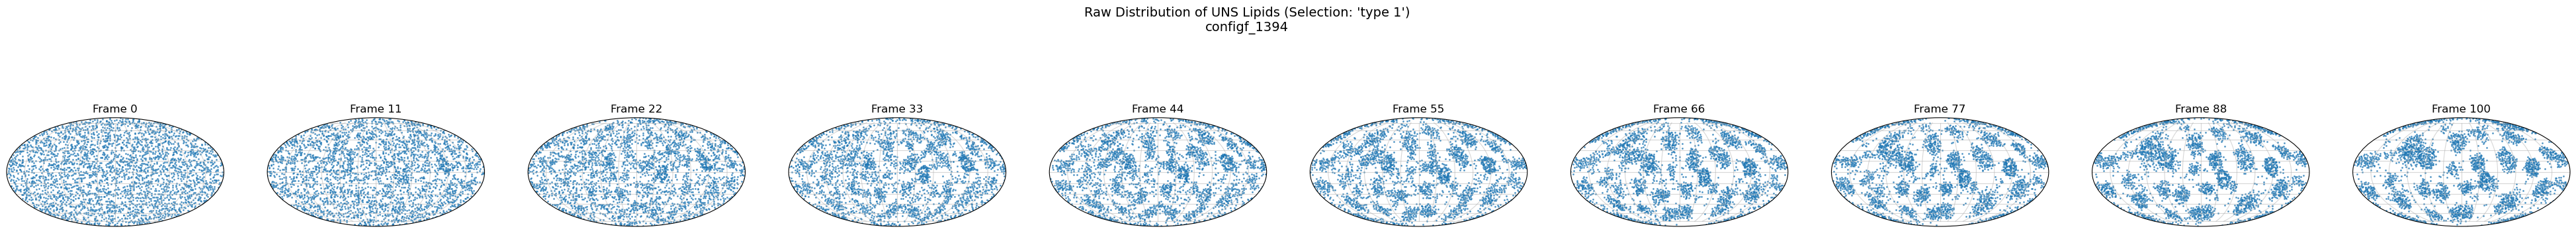

In [4]:
# Cell 8: Configuration for Raw Lipid Plotting
# These should match the selections used in your main analysis script
UNS_LIPID_SELECTION = "type 1"  # Example: Unsaturated lipid head bead
VESICLE_COM_SELECTION = "type 1 8 9" # All head beads for vesicle COM

# Number of frames to plot for this check (can be fewer than N_FRAMES_TO_PLOT)
N_RAW_FRAMES_TO_PLOT = min(10, len(selected_frame_indices)) # Plot 3 frames from the selected ones
raw_frames_for_scatter = selected_frame_indices[:N_RAW_FRAMES_TO_PLOT] if N_RAW_FRAMES_TO_PLOT > 0 else []

# Original simulation data path for configf_1394
# These are defaults from your main script, adjust if necessary for your setup
ORIG_TOPO_FILE = os.path.join(BASE_CONFIG_FOLDER, "bilayer.data")
ORIG_TRAJ_FILE = os.path.join(BASE_CONFIG_FOLDER, "concat-traj.lammpstrj")

print(f"Will attempt to load original trajectory from: {BASE_CONFIG_FOLDER}")
print(f"Plotting raw distribution for frames: {raw_frames_for_scatter}")

# Cell 9: Load MDAnalysis Universe for Raw Plotting
import MDAnalysis as mda

u_orig = None
if raw_frames_for_scatter.size > 0 : # Only load if we are plotting
    try:
        print(f"Loading Universe: {ORIG_TOPO_FILE}, {ORIG_TRAJ_FILE}")
        # Try with LAMMPSDUMP first, which often infers topology for data+lammpstrj
        u_orig = mda.Universe(ORIG_TOPO_FILE, ORIG_TRAJ_FILE, format="LAMMPSDUMP")
    except Exception as e_mda:
        print(f"Warning: Error loading Universe with format='LAMMPSDUMP': {e_mda}.")
        try:
            u_orig = mda.Universe(ORIG_TOPO_FILE, ORIG_TRAJ_FILE, topology_format='DATA', format='LAMMPSDUMP')
            print("Successfully loaded Universe with explicit topology_format='DATA'.")
        except Exception as e_mda_explicit:
            print(f"ERROR: Failed to load original MD Universe for {BASE_CONFIG_FOLDER}: {e_mda_explicit}")
            u_orig = None
    if u_orig:
        print(f"Original Universe loaded: {u_orig.atoms.n_atoms} atoms, {len(u_orig.trajectory)} frames.")

# Cell 10: Plot Raw Lipid Scatter on Mollweide Projection
if u_orig and raw_frames_for_scatter.size > 0:
    fig_scatter, axes_scatter = plt.subplots(
        nrows=1, ncols=N_RAW_FRAMES_TO_PLOT,
        figsize=(5 * N_RAW_FRAMES_TO_PLOT, 5),
        subplot_kw={'projection': 'mollweide'} # Key for Mollweide projection
    )
    if N_RAW_FRAMES_TO_PLOT == 1: # Ensure axes_scatter is iterable
        axes_scatter = [axes_scatter]

    fig_scatter.suptitle(f"Raw Distribution of UNS Lipids (Selection: '{UNS_LIPID_SELECTION}')\n{BASE_CONFIG_FOLDER}", fontsize=14)
    fig_scatter.subplots_adjust(top=0.85)


    for i, frame_idx in enumerate(raw_frames_for_scatter):
        ax = axes_scatter[i]
        ax.set_title(f"Frame {frame_idx}")
        ax.grid(True, alpha=0.5)
        # Remove default tick labels for Mollweide
        ax.set_xticklabels([])
        ax.set_yticklabels([])


        if frame_idx >= len(u_orig.trajectory):
            ax.text(0, 0, "Frame index\nout of bounds\nfor trajectory", ha='center', va='center') # Mollweide center is (0,0)
            continue

        u_orig.trajectory[frame_idx] # Go to the specified frame

        # Select all head beads for vesicle COM
        all_heads_ag = u_orig.select_atoms(VESICLE_COM_SELECTION)
        if all_heads_ag.n_atoms == 0:
            print(f"Frame {frame_idx}: No atoms selected for vesicle COM ('{VESICLE_COM_SELECTION}'). Skipping scatter.")
            ax.text(0, 0, "No COM atoms", ha='center', va='center')
            continue
        vesicle_com = all_heads_ag.center_of_mass()

        # Select the unsaturated lipids
        uns_lipids_ag = u_orig.select_atoms(UNS_LIPID_SELECTION)
        if uns_lipids_ag.n_atoms == 0:
            print(f"Frame {frame_idx}: No UNS lipids selected ('{UNS_LIPID_SELECTION}'). Skipping scatter.")
            ax.text(0, 0, "No UNS lipids", ha='center', va='center')
            continue

        # Get positions and shift by COM
        uns_positions = uns_lipids_ag.positions - vesicle_com

        # Convert Cartesian to spherical coordinates (phi, theta)
        x = uns_positions[:, 0]
        y = uns_positions[:, 1]
        z = uns_positions[:, 2]
        r = np.linalg.norm(uns_positions, axis=1)
        
        # Avoid division by zero for particles at the COM
        valid_r = r > 1e-6
        if not np.any(valid_r):
            print(f"Frame {frame_idx}: All UNS lipids are at the COM. Skipping scatter.")
            ax.text(0,0, "UNS lipids at COM", ha='center', va='center')
            continue

        x, y, z, r = x[valid_r], y[valid_r], z[valid_r], r[valid_r]

        phi = np.arctan2(y, x)  # Azimuth: [-pi, pi], 0 along +x
        theta_colat = np.arccos(z / r)  # Colatitude: [0, pi], 0 along +z

        # For matplotlib's Mollweide projection:
        # x-axis is longitude (phi) from -pi to pi.
        # y-axis is latitude from -pi/2 to pi/2. Latitude = pi/2 - Colatitude.
        latitude = np.pi/2 - theta_colat

        # Scatter plot
        # To match healpy's default mollview (often 'astro' flip where longitude increases to the left):
        # you might need to plot -phi.
        # If your healpy plots were 'geo' (longitude increases to the right), then phi is fine.
        # Let's plot phi directly first. If it's mirrored, try -phi.
        ax.scatter(phi, latitude, s=5, alpha=0.6, marker='.')
        # To match astro (healpy default if flip not specified):
        # ax.scatter(-phi, latitude, s=5, alpha=0.6, marker='.')


    plt.show()
elif raw_frames_for_scatter.size == 0:
    print("No frames selected for raw scatter plotting (or u_orig not loaded).")
else:
    print(f"MDAnalysis Universe 'u_orig' for {BASE_CONFIG_FOLDER} could not be loaded. Skipping raw scatter plot.")